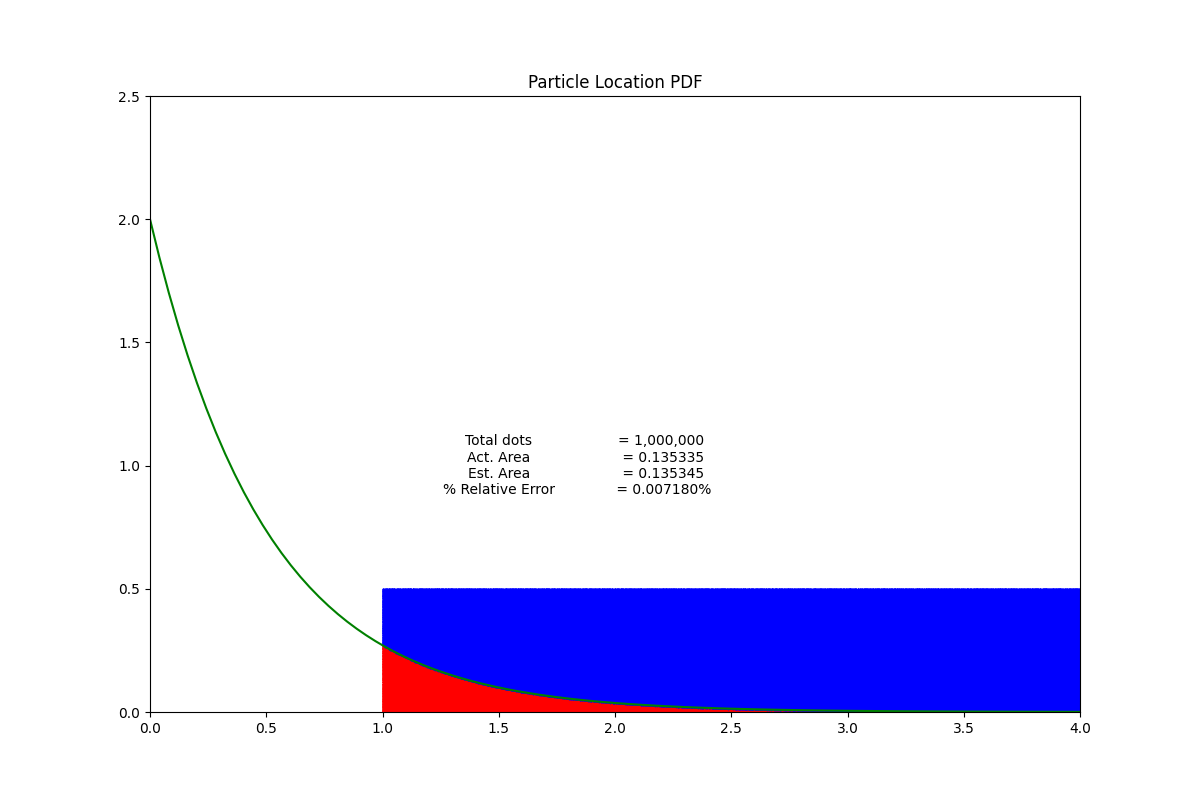

In [8]:
"""particle_location.ipynb"""
# Cell 1

%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle, Rectangle
from numba import float64, int32, vectorize
from numpy.random import default_rng
"""Mostly Dr. Biersach's solution and code from other programs"""
"""This program uses Monte Carlo to esimate and draw the PDF and estimate the 
probability that a particle will be found in the region x >= 1nm.
Cell 2 uses scipy to do all the hard work"""

sample_area = Rectangle((1, 0), 10, 0.5)

@vectorize([float64(float64)], nopython = True)
def pdf(x):
    return 2 * np.exp(-2 * x)

def cdf(x):
    return -np.exp(-2 * x)

@vectorize([float64(float64, float64)], nopython = True) #type: ignore
def hanlon(n: float, p: int) -> float:
    h = 0
    f = 1
    while n > 0:
        f: float = f / p
        h += (n % p) * f
        n = int(n / p)
    return h
    
def plot_pdf(ax):
    iterations = 1_000_000

    primes = [2, 3]

    x = (
        sample_area.get_x()
        + hanlon(np.arange(iterations), primes[0]) * sample_area.get_width()
    )

    y = (
        sample_area.get_y()
        + hanlon(np.arange(iterations), primes[1]) * sample_area.get_height()
    )

    d = pdf(x) - y

    x_in = x[d >= 0.0]
    y_in = y[d >= 0.0]

    x_out = x[d < 0.0]
    y_out = y[d < 0.0]

    pixel_size = (72 / ax.figure.dpi) ** 2
    ax.scatter(x_in, y_in, color = "red", marker = ".", s = pixel_size)
    ax.scatter(x_out, y_out, color = "blue", marker = ".", s = pixel_size)

    act_x = np.linspace(0, 4, 100)
    act_y = pdf(act_x)
    ax.plot(act_x, act_y, color = "green")

    est_area = ( #classic monte carlo estimations
        np.count_nonzero(d >= 0.0)
        / iterations
        * sample_area.get_width() * sample_area.get_height()
    )

    act_area = cdf(sample_area.get_x() + sample_area.get_width()) - cdf(
        sample_area.get_x()
    )

    err = (est_area - act_area) / act_area

    ax.set_title("Particle Location PDF")
    ax.set_xlim(0, 4.0)
    ax.set_ylim(0, 2.5)
    
    ax.text(1.5, 1.0, "Total dots\nAct. Area\nEst. Area\n% Relative Error", ha = "center", va = "center")
    ax.text(
        2.2,
        1.0,
        f"= {iterations:,}\n = {act_area:.6f}\n = {est_area:.6f}\n = {err:.6%}",
        ha = "center", va = "center",
    )

def main() -> None:
    plt.close("all")
    plt.figure(" ", figsize = (12, 8))
    plot_pdf(plt.axes())
    plt.show()

main()

In [9]:
# Cell 2

from scipy.integrate import quad
# Using scipy to integrate the pdf instead of doing it all from scratch
area_scipy = quad(pdf, 1, 100)[0]

print(f"Probability = {area_scipy:.6%}")

Probability = 13.533528%
